In [1]:
import joypy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# garbage
import gc; gc.enable()

# warnings
import warnings
warnings.filterwarnings("ignore")

# modeling
from sklearn.naive_bayes import GaussianNB
from sklego.mixture import GMMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklego.meta import Thresholder
from sklearn.pipeline import make_pipeline


In [2]:
df = pd.read_csv('clean_train_sample.csv')

In [3]:
df.head()

,Unnamed: 0,Review,Label
0,18288,"""Transylvania 6-5000"" is an insignificant but ...",0
1,19100,The Ogre doesn't seem to have won itself a ver...,1
2,20323,Joel schumacher Made a heck of a choice when h...,1
3,7027,I'm not entirely sure Rob Schmidt qualifies as...,1
4,4456,This is film that was actually recommended to ...,1


In [4]:
#seperate the target
target = df['Label']


In [5]:
!pip install --user -U nltk

Requirement already up-to-date: nltk in /Users/dylanlisk/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages (3.4.5)


In [6]:
#remove the target and review number
df.drop(['Label', 'Unnamed: 0'], axis=1, inplace=True)
df.head()

,Review
0,"""Transylvania 6-5000"" is an insignificant but ..."
1,The Ogre doesn't seem to have won itself a ver...
2,Joel schumacher Made a heck of a choice when h...
3,I'm not entirely sure Rob Schmidt qualifies as...
4,This is film that was actually recommended to ...


In [7]:
##doing something i dont know

In [8]:
from nltk.corpus import wordnet

In [9]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
import nltk

In [11]:
##more stuff i dont know

In [12]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [13]:
## function to clean text

In [14]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [15]:
## clean the text and add it to a new df

In [16]:
# clean_df = pd.DataFrame
# clean text data
df['clean_review'] = df["Review"].apply(lambda x: clean_text(x))
df

,Review,clean_review
0,"""Transylvania 6-5000"" is an insignificant but ...",transylvania insignificant occasionally funny ...
1,The Ogre doesn't seem to have won itself a ver...,ogre seem good reputation since release guess ...
2,Joel schumacher Made a heck of a choice when h...,joel schumacher make heck choice decide cast s...
3,I'm not entirely sure Rob Schmidt qualifies as...,i'm entirely sure rob schmidt qualifies master...
4,This is film that was actually recommended to ...,film actually recommend dentist glad blend bri...
...,...,...
4995,Shakespeare said that we are actors put into a...,shakespeare say actor put great stage stage is...
4996,"First of all, Jon Bon Jovi doesn't seem to be ...",first jon bon jovi seem place vampire movie to...
4997,"Sarafina was a fun movie, and some of the song...",sarafina fun movie song really great sarafina ...
4998,"Holy cow, what a piece of sh*t this movie is. ...",holy cow piece sh*t movie filmmaker could take...


In [17]:
##more shit i dont understand

In [18]:
gc.collect()

0

In [19]:
# nltk.download('vader_lexicon')

In [20]:
# clean_df.columns
# clean_df.rename(columns={0:'review'})
#whoops

In [21]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df['clean_review'].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [22]:
#add more stuff

In [23]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["Review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["Review"].apply(lambda x: len(x.split(" ")))

In [24]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["clean_review"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["clean_review"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["clean_review"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [26]:
#check work

In [27]:
reviews_df.head()


,Review,clean_review,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,...,word_youth,word_youthful,word_yuppie,word_zane,word_zero,word_zip,word_zombie,word_zombies,word_zone,word_zoom
0,"""Transylvania 6-5000"" is an insignificant but ...",transylvania insignificant occasionally funny ...,0.126,0.598,0.276,0.9770,1620,267,0.910555,-0.181520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Ogre doesn't seem to have won itself a ver...,ogre seem good reputation since release guess ...,0.065,0.656,0.278,0.9930,2217,409,0.720246,-0.287142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Joel schumacher Made a heck of a choice when h...,joel schumacher make heck choice decide cast s...,0.115,0.587,0.298,0.9552,912,170,0.381708,-0.023392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I'm not entirely sure Rob Schmidt qualifies as...,i'm entirely sure rob schmidt qualifies master...,0.279,0.525,0.196,-0.9913,2492,414,0.625275,-0.372613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,This is film that was actually recommended to ...,film actually recommend dentist glad blend bri...,0.067,0.646,0.286,0.9392,662,123,0.270511,-0.308957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


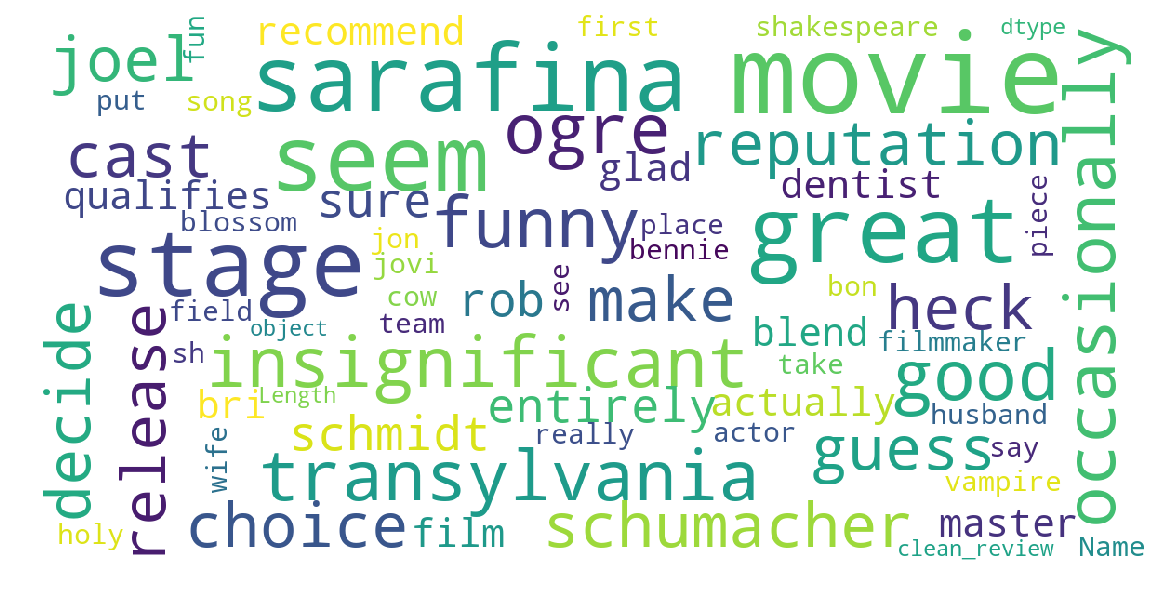

In [28]:
# wordcloud function
#cool graph

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["clean_review"])

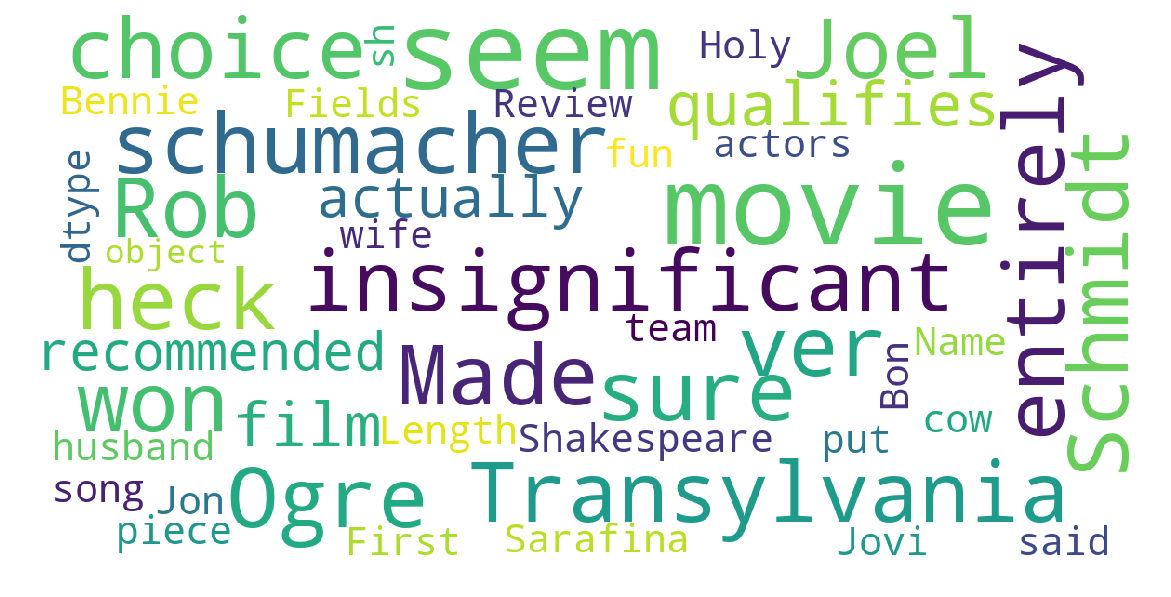

In [29]:
show_wordcloud(reviews_df["Review"])

In [30]:
###the results of this worry me

In [31]:
label = "is_bad_review"
ignore_cols = [label, "Review", "clean_review"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier

In [32]:
reviews_df.columns

Index(['Review', 'clean_review', 'neg', 'neu', 'pos', 'compound', 'nb_chars',
       'nb_words', 'doc2vec_vector_0', 'doc2vec_vector_1',
       ...
       'word_youth', 'word_youthful', 'word_yuppie', 'word_zane', 'word_zero',
       'word_zip', 'word_zombie', 'word_zombies', 'word_zone', 'word_zoom'],
      dtype='object', length=5675)

In [33]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(reviews_df[features], target)
 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
y_guess = rf.predict(reviews_df[features])

In [35]:
accuracy_score(y_guess, target)

1.0

In [36]:
df2 = pd.read_csv('clean_test_sample.csv')
df2

,Unnamed: 0,Review,Label
0,8638,I'm a fan of Get Shorty. This is the sequel fo...,0
1,6385,This film was so bad it became enjoyable. If y...,0
2,20716,"To be honest fellow IMDb reviewers, I enjoyed ...",1
3,23102,"After having watched Darwin's Nightmare, one m...",0
4,11328,"There are spoilers but trust me, I'm doing you...",0
...,...,...,...
4995,17092,Caddyshack II is NOTHING compared to the origi...,0
4996,4764,The Happiest Days of Your Life showcases some ...,1
4997,9691,"Before I begin, a ""little"" correction: IMDb st...",0
4998,327,I'm working my way through the Horror Classics...,0


In [37]:
target2 = df2['Label']
#isolate target
# remove target
df2.drop(['Unnamed: 0', 'Label'], axis=1, inplace=True)

In [38]:
# clean text data
df2['clean_review'] = df2["Review"].apply(lambda x: clean_text(x))
df2

,Review,clean_review
0,I'm a fan of Get Shorty. This is the sequel fo...,i'm fan get shorty sequel movie need sequel.<b...
1,This film was so bad it became enjoyable. If y...,film bad become enjoyable want see soap opera ...
2,"To be honest fellow IMDb reviewers, I enjoyed ...",honest fellow imdb reviewer enjoy show lot rea...
3,"After having watched Darwin's Nightmare, one m...",watch darwin's nightmare one must impression t...
4,"There are spoilers but trust me, I'm doing you...",spoiler trust i'm favor.<br br friend like wat...
...,...,...
4995,Caddyshack II is NOTHING compared to the origi...,caddyshack ii nothing compare original caddysh...
4996,The Happiest Days of Your Life showcases some ...,happiest day life showcases britain's great co...
4997,"Before I begin, a ""little"" correction: IMDb st...",begin little correction imdb state richard ger...
4998,I'm working my way through the Horror Classics...,i'm work way horror classic movie pack collect...


In [39]:
df2["sentiments"] = df2['clean_review'].apply(lambda x: sid.polarity_scores(x))
reviews_df2 = pd.concat([df2.drop(['sentiments'], axis=1), df2['sentiments'].apply(pd.Series)], axis=1)

In [40]:
# add number of characters column
reviews_df2["nb_chars"] = reviews_df2["Review"].apply(lambda x: len(x))

# add number of words column
reviews_df2["nb_words"] = reviews_df2["Review"].apply(lambda x: len(x.split(" ")))

In [41]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df2["clean_review"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df2["clean_review"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df2 = pd.concat([reviews_df2, doc2vec_df], axis=1)

In [65]:
#check DF
reviews_df2.head()
reviews_df2.iloc[1]

Review          This film was so bad it became enjoyable. If y...
clean_review    film bad become enjoyable want see soap opera ...
neg                                                         0.117
neu                                                         0.649
pos                                                         0.235
                                      ...                        
word_zip                                                        0
word_zombie                                                     0
word_zombies                                                    0
word_zone                                                       0
word_zoom                                                       0
Name: 1, Length: 5675, dtype: object

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.transform(reviews_df2["clean_review"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df2.index
reviews_df2 = pd.concat([reviews_df2, tfidf_df], axis=1)

In [44]:
label = "is_bad_review"
ignore_cols = [label, "Review", "clean_review"]
features2 = [c for c in reviews_df2.columns if c not in ignore_cols]

In [45]:
y_test = rf.predict(reviews_df2[features2])

In [46]:
accuracy_score(y_test,target2)

0.811

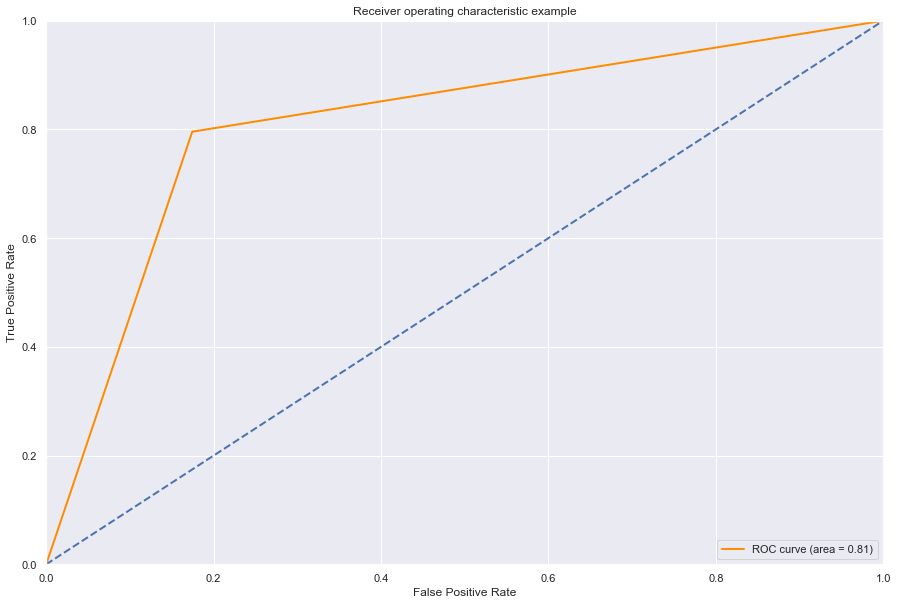

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(reviews_df2[features2])]
fpr, tpr, thresholds = roc_curve(target2, y_test, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.model_selection import cross_val_score

In [49]:
scores2 = cross_val_score(rf, reviews_df2[features2], target2, scoring='roc_auc', cv=5, n_jobs=-1 )

In [50]:
scores2

array([0.90022687, 0.89170158, 0.88910433, 0.90138827, 0.89571838])

In [51]:
reviews_df[features]

,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,...,word_youth,word_youthful,word_yuppie,word_zane,word_zero,word_zip,word_zombie,word_zombies,word_zone,word_zoom
0,0.126,0.598,0.276,0.9770,1620,267,0.910555,-0.181520,-0.925636,-0.078065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.065,0.656,0.278,0.9930,2217,409,0.720246,-0.287142,-0.473291,-0.525160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.115,0.587,0.298,0.9552,912,170,0.381708,-0.023392,-0.347258,-0.104538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.279,0.525,0.196,-0.9913,2492,414,0.625275,-0.372613,-0.819694,-0.555030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.067,0.646,0.286,0.9392,662,123,0.270511,-0.308957,-0.399848,-0.057669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.010,0.689,0.300,0.9899,1260,225,0.482197,-0.452676,-0.466061,0.043815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.110,0.706,0.183,0.5106,446,81,0.150826,-0.124407,-0.045271,-0.199976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.194,0.622,0.184,-0.2585,2186,388,0.365998,-0.605798,-1.118514,-0.102072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.112,0.617,0.270,0.9274,791,149,-0.048381,-0.195732,-0.622264,-0.153976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
scores = cross_val_score(rf, reviews_df[features], target, scoring='accuracy', cv=5, n_jobs=-1 )

In [53]:
scores
print('mean',scores.mean(),'------STD',scores.std())

mean 0.8103999999999999 ------STD 0.01155162326255488


In [54]:
print('mean',scores2.mean(),'------STD',scores2.std())

mean 0.8956278848183834 ------STD 0.0047394837566158525


In [56]:
review = 'The movie wasnt actually that bad it surprised me i thought i ould hate it but i didnt but i actually work'